In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch import nn


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channel):
        super().__init__()
        self.block=nn.Sequential(
            nn.ReflectionPad2d(
               1,
            ),
            nn.Conv2d(in_channels=in_channel,out_channels=in_channel,kernel_size=3),
            nn.InstanceNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=in_channel,out_channels=in_channel,kernel_size=3),
            nn.InstanceNorm2d(in_channel),
            
        )

    
    def forward(self,X):
        return X + self.block(X)



In [3]:
class GeneratorResNet(nn.Module):
    def __init__(self,input_shape,num_residual_blocks):
        super().__init__()
        channels=input_shape[0]
        out_channels=64
        model=[
            nn.ReflectionPad2d(channels),
            nn.Conv2d(in_channels=channels,out_channels=out_channels,kernel_size=7,stride=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
            
        ]
        in_channels=out_channels
       
        for _ in range(2):
            out_channels*=2
            model +=[
                nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=2,padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels=out_channels
            
       
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_channels)]

        
        for _ in range(2):
            out_channels //= 2
            model +=[
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=1,padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
                    
            ]
            in_channels=out_channels
            
       
        model +=[
            nn.ReflectionPad2d(channels),
            nn.Conv2d(in_channels=out_channels,out_channels=channels,kernel_size=7),
            nn.Tanh()
            
        ]
        self.model=nn.Sequential(*model)

    
    def forward(self,X):
        return self.model(X)
        
        

        

In [4]:
class Discriminator(nn.Module):
    def __init__(self,input_shape):
        super().__init__()
        channels,height,width=input_shape
        
        
        self.output_shape=(1,height//2**4,width//2**4)
        def discriminator_block(in_channels,out_channels,normalize=True):
            layers=[
                nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=4,stride=2,padding=1)
            ]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2,inplace=True))
            return layers
            
        # C64 -> C128 -> C256 -> C512
        self.model=nn.Sequential(
            *discriminator_block(in_channels=channels,out_channels=64,normalize=False),
            *discriminator_block(64, out_channels=128),
            *discriminator_block(128, out_channels=256),
            *discriminator_block(256, out_channels=512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,padding=1)
            
        )

    
    def forward(self,X):
        return self.model(X)
        
                
        

In [5]:
input_shape = (3, 128,128)
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device:{device}")

Using device:cuda


In [6]:
Gen_AB=GeneratorResNet(input_shape=input_shape,num_residual_blocks=15).to(device)
Gen_BA=GeneratorResNet(input_shape=input_shape,num_residual_blocks=15).to(device)
Disc_A=Discriminator(input_shape=input_shape).to(device)
Disc_B=Discriminator(input_shape=input_shape).to(device)

In [7]:
Gen_AB.load_state_dict(torch.load('Gen-AB-PreWeights-9.pth')['Gen_AB'])
Gen_BA.load_state_dict(torch.load('Gen-BA-PreWeights-9.pth')['Gen_BA'])
Disc_A.load_state_dict(torch.load('Disc-A-PreWeights-9.pth')['Disc_A'])
Disc_B.load_state_dict(torch.load('Disc-B-PreWeights-9.pth')['Disc_B'])

<All keys matched successfully>

In [8]:
total_params = sum(p.numel() for p in Gen_AB.parameters()) + sum(p.numel() for p in Gen_BA.parameters()) + sum(p.numel() for p in Disc_A.parameters()) + sum(p.numel() for p in Disc_B.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 42447752


In [9]:
Tensor= torch.cuda.FloatTensor if device == "cuda" else torch.Tensor
Tensor

torch.cuda.FloatTensor

In [10]:
test_transform= transforms.Compose([
    transforms.Resize((128,128), Image.BICUBIC),  
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.RandomRotation(degrees=15),         
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)), 
    transforms.ToTensor(),                         
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  
])


In [11]:
import random
def plot_transformationWM(path:str):
    test_img=Image.open(path)
    test_transform=transforms.Compose( [
        transforms.Resize((128, 128), Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    test_img=test_transform(test_img)
    
    with torch.inference_mode():
        test_img=test_img.unsqueeze(dim=0)
        test_img=Variable(test_img.type(Tensor))
        model_pred=Gen_BA(test_img)
        
    denormalize = transforms.Normalize(
        mean=[-1, -1, -1],
        std=[2, 2, 2]
    )
    model_pred_denorm = denormalize(model_pred.squeeze(dim=0))    
    model_pred_denorm = torch.clamp(model_pred_denorm, 0, 1)
    plt.figure(figsize=(15,20))
    plt.subplot(1,2,1)
    plt.imshow(Image.open(path))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(model_pred_denorm.squeeze(dim=0).permute(1,2,0).cpu().numpy())
    plt.title("Transformed Image")
    random_title="random"+ str(random.randint(0,10000))
    plt.savefig(f'{random_title}.png',bbox_inches='tight',dpi=300)
    

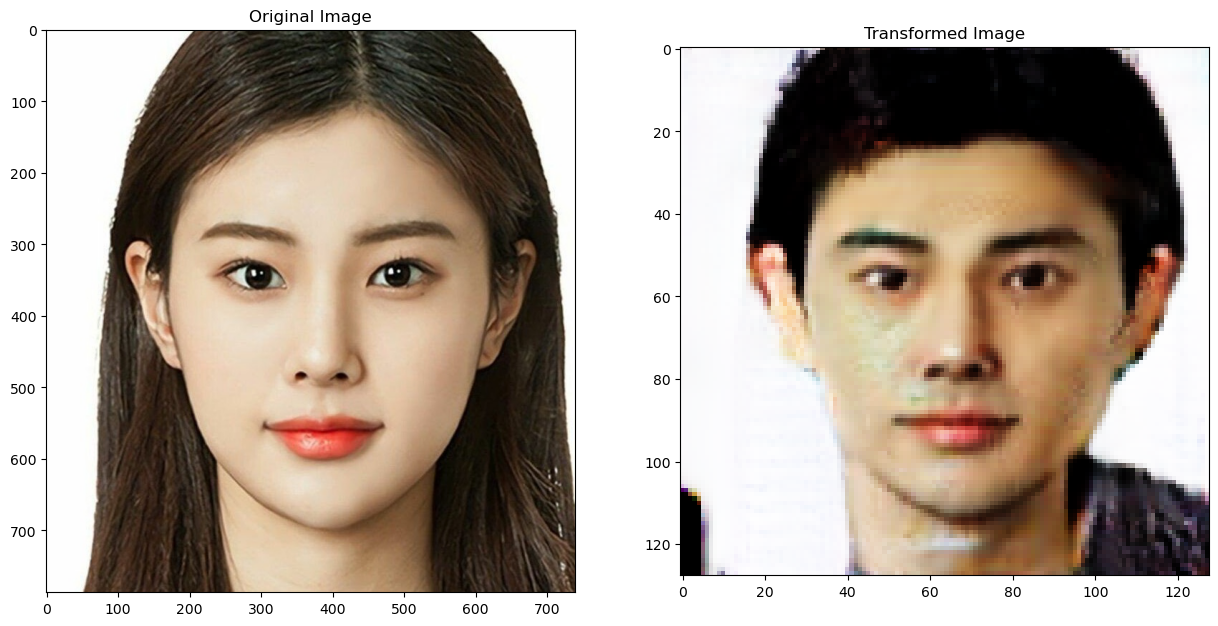

In [12]:
plot_transformationWM('genderchange/testB/woman_3999.jpg')

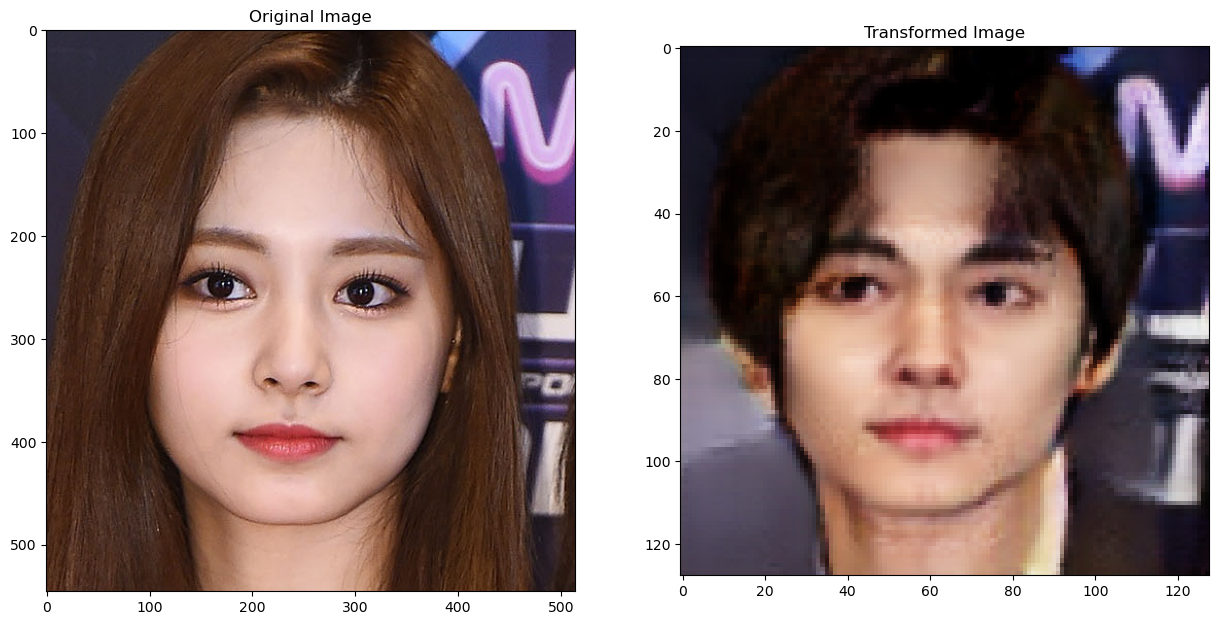

In [13]:
plot_transformationWM('genderchange/testB/woman_530.jpg')

In [14]:
def plot_transformationMW(path:str):
    test_img=Image.open(path)
    test_transform=transforms.Compose( [
        transforms.Resize((128, 128), Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    test_img=test_transform(test_img)
    
    with torch.inference_mode():
        test_img=test_img.unsqueeze(dim=0)
        test_img=Variable(test_img.type(Tensor))
        model_pred=Gen_AB(test_img)
        
    denormalize = transforms.Normalize(
        mean=[-1, -1, -1],
        std=[2, 2, 2]
    )
    model_pred_denorm = denormalize(model_pred.squeeze(dim=0))
    
    
    
    model_pred_denorm = torch.clamp(model_pred_denorm, 0, 1)
    
    plt.figure(figsize=(15,20))
    plt.subplot(1,2,1)
    plt.imshow(Image.open(path))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(model_pred_denorm.squeeze(dim=0).permute(1,2,0).cpu().numpy())
    plt.title("Transformed Image")
    random_title="random"+ str(random.randint(0,10000))
    plt.savefig(f'{random_title}.png',bbox_inches='tight',dpi=300)
    

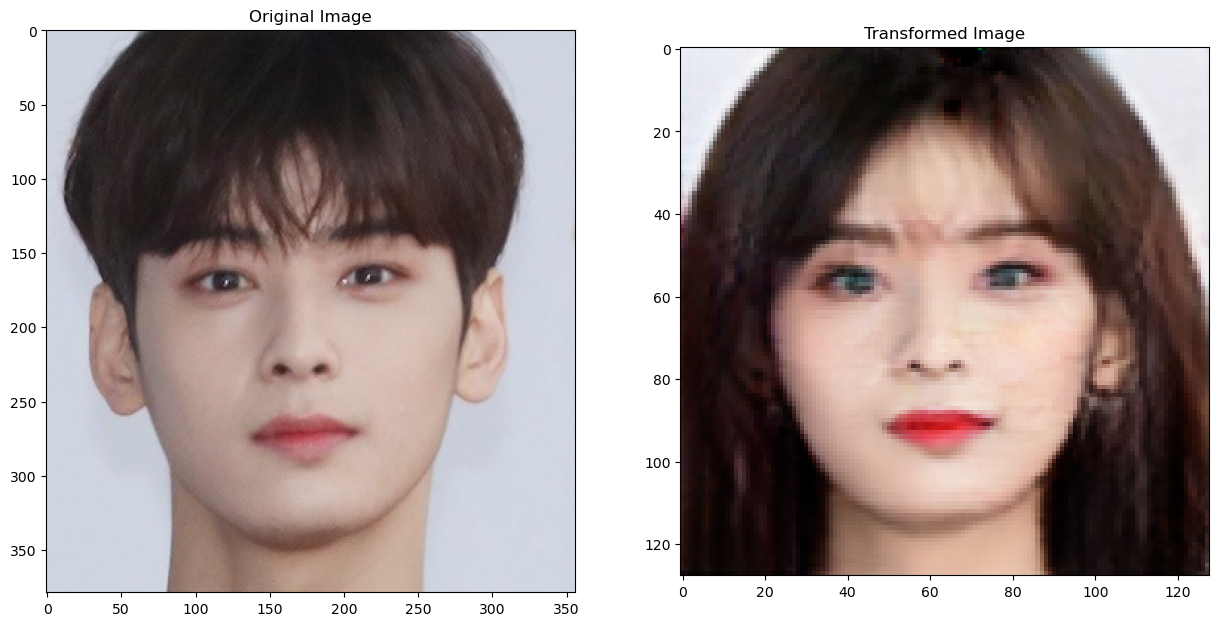

In [15]:
plot_transformationMW('genderchange/testA/man_717.jpg')

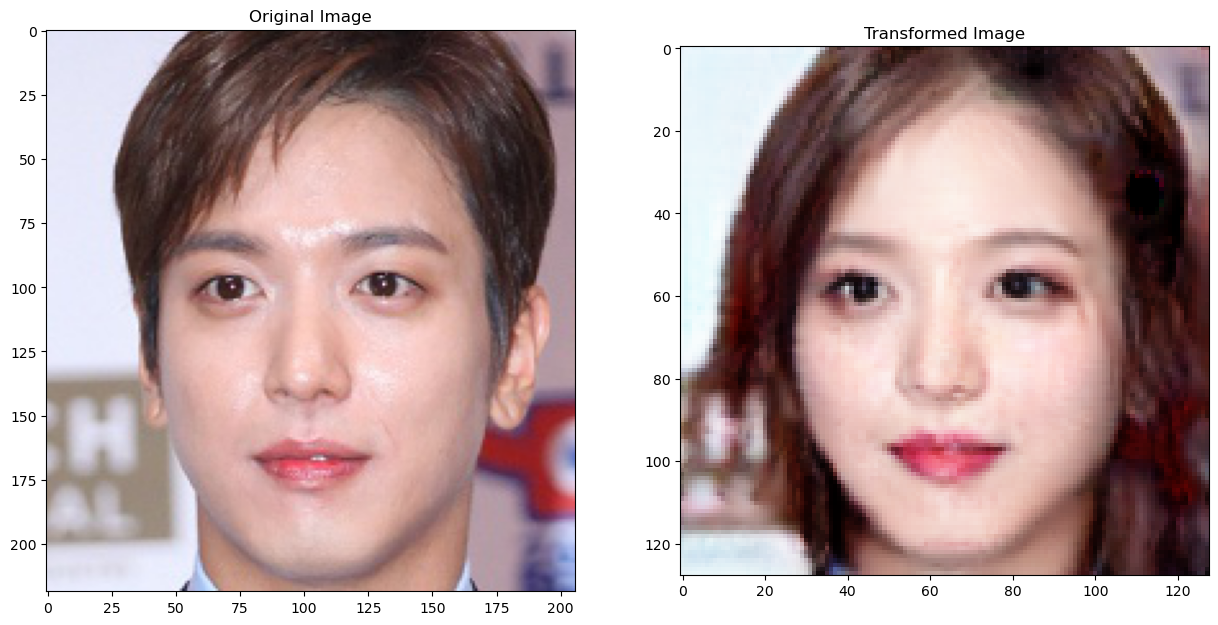

In [16]:
plot_transformationMW('genderchange/testA/man_930.jpg')